In [1]:
%matplotlib inline

import load_local_neo_odml_elephant
import os

import numpy as np
from autograd import grad, jacobian
import numdifftools as nd
import imageio
import random
import math
import time
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy import optimize
from scipy.fft import rfft, rfftfreq, ifft
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import gridspec, ticker, colors
from matplotlib.pyplot import rcParams
from mpl_toolkits import mplot3d
import matplotlib.patches as patches

from reachgraspio import reachgraspio
import odml.tools
import neo_utils
import odml_utils
import quantities as pq

from elephant.signal_processing import butter
from neo import Block, Segment

rcParams.update({'font.size': 13})
rcParams['figure.autolayout'] = True
rcParams['legend.fontsize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['axes.titlepad'] = 10
rcParams['axes.labelpad'] = 20
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['mathtext.fontset'] = 'cm' 
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']  


elephant/elephant/spade.py:80: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  warnings.warn(


### Functions

In [2]:
def get_monkey_datafile(monkey):
    if monkey == "Lilou":
        return "l101210-001"  # ns2 and ns5 present
    elif monkey == "Nikos2":
        return "i140703-001"  # ns2 and ns6 present
    else:
        return ""

def autocorr(x,lags): 
    """
    Autocorrelation function for data and network response 
    """
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
    
def nonlinearity(x, theta=0, phi_max=1):
    """
    Network nonlinearity (positive sigmoid)
    """
    return phi_max / (1 + np.exp(-(x-theta)))

def get_noise(N, n_trials, tau_wn, amp_wn, mean_wn):
    """
    Define Ornstein-Uhlenbeck noise input 
    """
    noises = []
    for trial in range(n_trials):  
        noise = np.zeros((N, iterations))
        for i in range(iterations-1):
            noise[:, i+1] = noise[:, i] + ((mean_wn - noise[:, i]) / tau_wn) + amp_wn * np.sqrt(2*dt/tau) * np.random.randn(N)
        noises.append(noise)
    return noises 

def get_timepoints(len_train, n_trials, n_repeats):
    """
    Define training and testing epochs
    """
    
    timepoints = np.arange(0, (len_train + n_trials) * (n_trials * n_repeats))
    timepoints = np.reshape(timepoints, (-1, len_train + n_trials))

    trains = []
    tests = []
    for trial in range(n_trials):
        train_reps = []
        test_reps = []
        for repeat in range(n_repeats):
            train_reps.append(timepoints[trial + n_trials*repeat, :len_train])
            test_reps.append(timepoints[trial + n_trials*repeat, -n_trials:])
        trains.append(np.vstack(train_reps))
        tests.append(np.vstack(test_reps))

    a, b = timepoints.shape
    n_tot = a*b
    
    return timepoints, trains, tests, n_tot

def tau_to_ms(tau):
    """
    Conversion factor from network timescale to ms
    """
    return tau * ((rescale_ms[-1].magnitude / max_length))

def ms_to_tau(ms):
    """
    Conversion factor from ms to network timescale
    """
    return ms /  ((rescale_ms[-1].magnitude / max_length))

def eigval_to_hz(eigval):
    """
    Conversion factor from eigenvalues of Jacobian to Hz
    """
    return eigval / ((rescale_ms[-1].magnitude / max_length) / 1000) / (np.pi * 2) 

def hz_to_eigval(hz):
    """
    Conversion factor from Hz to eigenvalues of Jacobian
    """
    return hz * ((rescale_ms[-1].magnitude / max_length) / 1000) * (np.pi * 2) 


# General parameters

amplitude_unit = pq.microvolt
time_unit = pq.ms
Writer = animation.writers['ffmpeg']
writer = Writer(fps=50, bitrate=1800)

main_color = 'darkcyan'
main_color_dark = 'darkslategrey'
positive_color = 'darkgreen'
negative_color = 'darkred'

folder = 'duplicates_multiple'

### Load session and split into trials

In [3]:
# Specify directory where the data is stored
datasetdir = "/Users/administrator/multielectrode_grasp/datasets/"

# Specify which monkey to analyse
monkey = 'Lilou'

nsx_none = {'Lilou': None, 'Nikos2': None}
nsx_lfp = {'Lilou': 2, 'Nikos2': 2}
nsx_raw = {'Lilou': 5, 'Nikos2': 6}

datafile = get_monkey_datafile(monkey)

# Open the session for reading
session = reachgraspio.ReachGraspIO(filename=os.path.join(datasetdir, datafile), odml_directory=datasetdir)

# Read the first 50s of data from chosen number of electrodes

chosen_els = range(100)
chosen_units = 1

bl_raw = session.read_block(
    nsx_to_load=nsx_raw[monkey],
    n_starts=None,
    n_stops=50 * pq.s,
    channels=chosen_els,
    units=chosen_units,
    load_waveforms=False,
    load_events=True,
    scaling='voltage',
    lazy=False,
    cascade=True,
    correct_filter_shifts=True)

# Access the single segment of the data block, containing all trials 
assert len(bl_raw.segments) == 1
seg_raw = bl_raw.segments[0]  # there is only 1 segment 


warning[None:17:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag (line 17)
warning[None:17:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML> (line 17)


In [4]:
# Get start and stop events of trials with correct performance
start_events = neo_utils.get_events(
    seg_raw,
    properties={
        'name': 'TrialEvents',
        'trial_event_labels': 'CUE-OFF',
        'performance_in_trial': 255})
stop_events = neo_utils.get_events(
    seg_raw,
    properties={
        'name': 'TrialEvents',
        'trial_event_labels': 'GO-ON',
        'performance_in_trial': 255})

assert len(start_events) == 1
assert len(stop_events) == 1

# Create epochs around start and stop events 
epoch = neo_utils.add_epoch(
    seg_raw,
    start_events[0],
    stop_events[0],
    pre = +50 * pq.ms,
    post = -250 * pq.ms,
    trial_status='complete_trials',
    trial_type=start_events[0].annotations['belongs_to_trialtype'],
    trial_performance=start_events[0].annotations['performance_in_trial'])

raw_block = Block(name='raw_analysis_epoch')
raw_block.segments = neo_utils.cut_segment_by_epoch(seg_raw, epoch, reset_time=True)  # each segment = 1 trial


### Create targets from filtered LFP signals

96
96
96
96
96


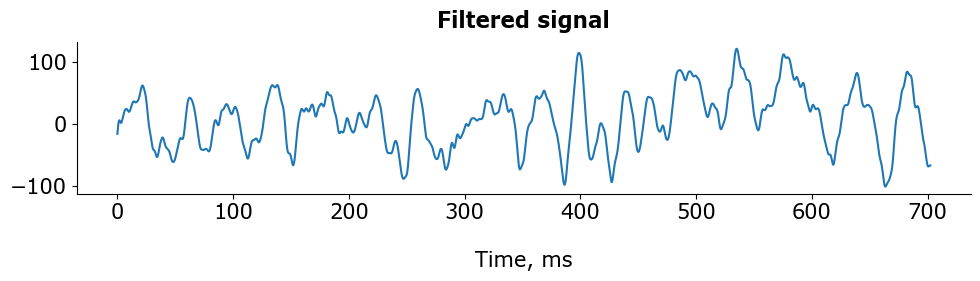

In [5]:
# Choose trials

trial_ids = [6, 3, 2, 7, 8]
n_signals = len(raw_block.segments[0].analogsignals)
filtered_signals = []

for trial in trial_ids:
    filtered_anasig = []
    print(len(raw_block.segments[trial].analogsignals))
    for anasig in raw_block.segments[trial].analogsignals:
        f_anasig = butter(
                anasig,
                highpass_freq=None,
                lowpass_freq=250 * pq.Hz,
                order=4)
        f_anasig.name = 'offline_lfp_%s' % anasig.name 
        filtered_anasig.append(f_anasig)

    # Attach all offline filtered LFPs to the raw_block segment of each trial 
    raw_block.segments[trial].analogsignals.extend(filtered_anasig)

    # Separate raw and filtered signals 
    raw_sigs = raw_block.segments[trial].analogsignals[0:n_signals]
    filtered_sigs = raw_block.segments[trial].analogsignals[n_signals:]
    filtered_signals.append(filtered_sigs)
    
# Find signal with shortest length
shortest = np.argmin([len(x[0]) for x in filtered_signals])
rescale_ms = filtered_signals[shortest][0].times.rescale(pq.ms)
max_length = min([len(x[0]) for x in filtered_signals])
rescale_ms_ds = rescale_ms[::10]
max_time_ds = len(rescale_ms_ds)
    
# Plot to check 
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
ax.plot(rescale_ms, filtered_signals[0][0].squeeze().rescale(pq.microvolt)[:max_length])
ax.set_xlabel(r'$t$, ms')
ax.set_title('Filtered signal', fontweight='bold')
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.show()


In [6]:
# Create targets from filtered signals
targets = []
targets_ds = []

for filtered_sig in filtered_signals:
    targets_unselected = []
    for sig in filtered_sig:
            targets_unselected.append(sig.squeeze().rescale(amplitude_unit))

    remove_idxs = [42] 
    for idx, timeseries in enumerate(targets_unselected):
        if np.max(np.abs(timeseries)) > 250:
            remove_idxs.append(idx)

    targets_unselected = [x.magnitude for x in targets_unselected]
    targets_trial = np.vstack(targets_unselected)

    for bad in remove_idxs:
        targets_trial[bad] = 0.0

    targets_trial = targets_trial/targets_trial.max()
    targets_trial_ds = np.squeeze([x[::10] for x in targets_trial])

    targets.append(targets_trial)
    targets_ds.append(targets_trial_ds)

targets_duplicated = []
for x in targets:
    targets_duplicated.append(np.vstack((x, x, x)))

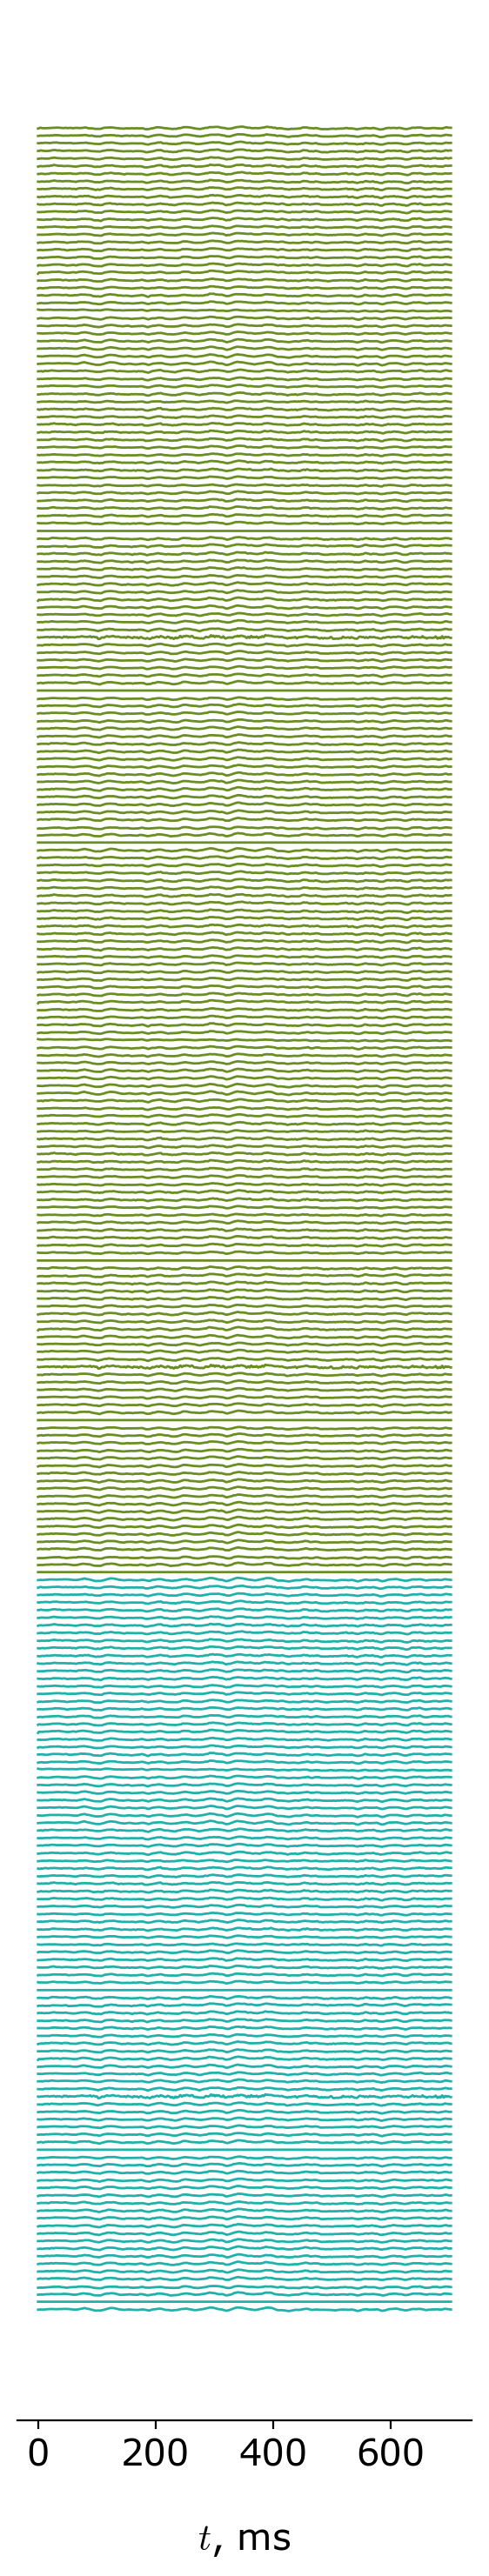

In [7]:
# Plot targets

fig, ax = plt.subplots(figsize=(3, 15), dpi=200)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, len(targets_duplicated[0])))

for i in range(len(targets_duplicated[0])): 
    if i <= 96:
        color = 'lightseagreen'
    else:
        color = 'olivedrab'
    ax.plot(rescale_ms, targets_duplicated[1][i, :max_length] + 3.4*i , color=color, linewidth=1)

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.savefig('multiple_positive_sigmoid_delay/targets.png', dpi=200)
plt.show()


### Network architecture

In [316]:
# Network parameters
N = len(targets_duplicated[0]) 
n_targets = len(targets_duplicated[0]) 
dt_weight_update = 10
alpha = 1 
g = 1.5
tau = 100
D = 0

# Timescale  parameters
T = max_length
dt = 1 
iterations = int(T/dt)  
times = np.linspace(0, T, iterations)

# Define timepoints 
len_train = 15
n_trials = 4
n_repeats = 2
timepoints, trains, tests, n_tot = get_timepoints(len_train, n_trials, n_repeats)

# Define noise
tau_trial = 1000
amp_trial = 0.02
tau_baseline = 400
amp_baseline = 0.03

taus_baseline = np.linspace(100, 400, N)
amps_baseline = np.linspace(0.01, 0.03, N)
taus_trial = np.linspace(500, 600, N)
amps_trial = np.linspace(0.00, 0.03, N)

noise_trial = get_noise(N, n_trials, tau_trial, amp_trial, 0.0)
noise_baseline = get_noise(N, 1, tau_baseline, amp_baseline, 0.0)
noise_baseline_graded = get_noise(N, 1, taus_baseline, amps_baseline, 0)  
noise_trial_graded = get_noise(N, n_trials, taus_trial, amps_trial, 0)

# Weight matrices 
P = np.eye(n_targets) / alpha
J0 = np.random.randn(N, N) * g / np.sqrt(N)
J = J0.copy()

J_evolution = []
J_evolution.append(J0)
save_J_every = int(n_tot/5)  # modify this

zs_all = []
mses = []
deltas_all = np.zeros(n_targets)  
deltas_all = deltas_all[:, None]

start_time = time.time()

for run in range(n_tot):
    
    if run%10 == 0:
        print(int((run/n_tot)*100), '%')

    xs = np.zeros((N, iterations))  
    zs = np.zeros((N, iterations)) 
    deltas = np.zeros((n_targets, iterations)) 
    mse = []

    if run>0:
        xs[:, 0] = last_run
    
    for t in range(D, iterations-1):
        for trial in range(n_trials):
            if run in trains[trial] or run in tests[trial]:
                xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_trial_graded[trial][:, t] + noise_baseline_graded[0][:, t]) * dt / tau
                r = nonlinearity(xs[:, t-D])  # t-D or t+1?
                r = r[:, None]    
                zs[:, t+1] = J.dot(np.squeeze(r))
                
                errs = zs[:n_targets, t+1] - targets_duplicated[trial][:, t+1]
                mse.append(np.mean(errs)**2)

                if run in trains[trial] and t % dt_weight_update == 0:

                    k = P.dot(r[:n_targets])
                    rPr = r[:n_targets].T.dot(k)
                    c = 1.0 / (1.0 + rPr)
                    P = P - c * (k.dot(k.T))
                    delta_w = - (c * np.outer(errs, k))
                    deltas[:, t] = np.linalg.norm(delta_w, axis=0)

                    J[:n_targets, :n_targets] += delta_w
                    J[np.isclose(J, 0.0, atol=1e-04)] = 0.0
                    
    last_run = xs[:, -1]
    
    if run % save_J_every == 0:
        J_current = J.copy()
        J_evolution.append(J_current)
        
    mses.append(np.mean(mse))
    zs_all.append(zs)
    deltas_all = np.concatenate((deltas_all, deltas), axis=1)
    
print('Time elapsed: %.2f' % ((time.time() - start_time)/60) + ' min')

0 %
6 %
13 %
19 %
26 %
32 %
39 %
46 %
52 %
59 %
65 %
72 %
78 %
85 %
92 %
98 %
Time elapsed: 642.21 min


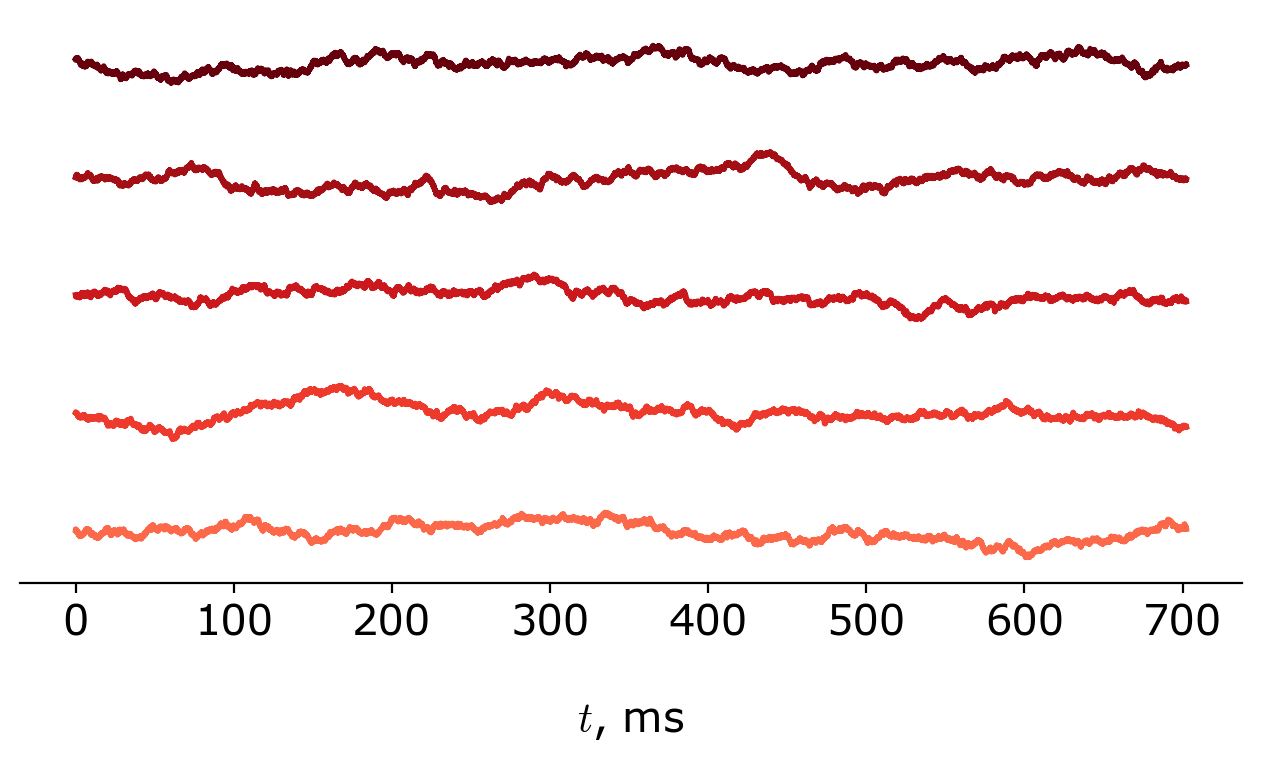

In [307]:
# Plot graded noise inputs

fig, ax = plt.subplots(figsize=(6.5, 4), dpi=200)
colors = pl.cm.Reds(np.linspace(0.5, 1, 5))

for ind, val in enumerate(np.linspace(0, N-1, 5, dtype='int')):
#     ax.plot(rescale_ms, noise_baseline_graded[0][val, :] + ind, color=colors[ind], alpha=1, lw=2)
    ax.plot(rescale_ms, noise_trial[0][val, :] + ind, color=colors[ind], alpha=1, lw=2)

ax.set_xlabel('$t$, ms', labelpad=20)
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.savefig('%s/noise_inputs.png'%folder, dpi=200)
plt.show()

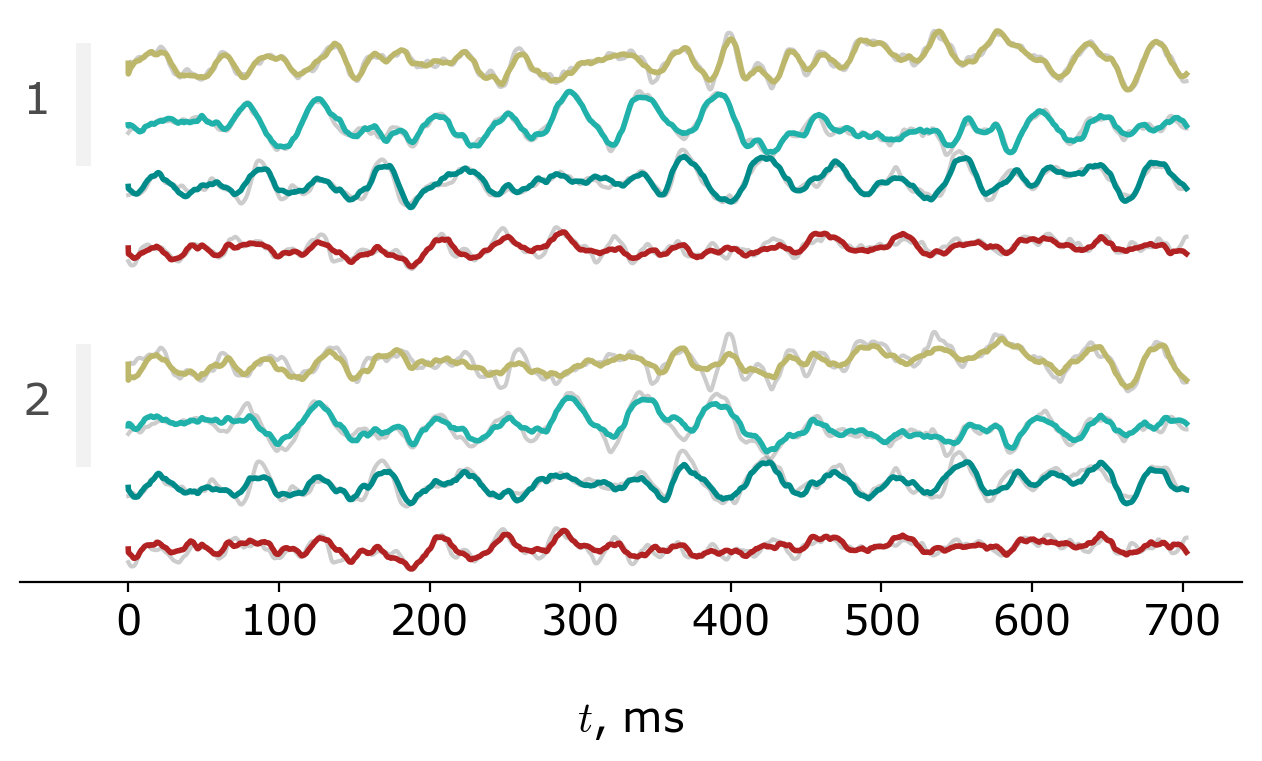

In [308]:
# Plot readout versus target for selection of neurons

fig, axs = plt.subplots(n_repeats, 1, figsize=(6.5, 2*n_repeats), dpi=200)
color_palette = ['darkkhaki', 'lightseagreen', 'darkcyan', 'firebrick']

for repeat in range(n_repeats):
    
    for trial in range(n_trials):
        
        index = timepoints[trial + (n_trials * repeat), - n_trials + trial]
        axs[repeat].plot(rescale_ms, targets_duplicated[trial][0, :max_length] - 1.5*trial, color='grey', alpha=0.4)   # Target functions
        axs[repeat].plot(rescale_ms[:-1], zs_all[index][0, :max_length-1] - 1.5*trial, color=color_palette[trial], linewidth=2)  # Network presynaptic currents
        
    axs[repeat].text(-70, -1.2, '%s' % (repeat+1), color='k', alpha=0.7, rotation=0, fontsize=16)
    axs[repeat].add_patch(patches.Rectangle((-35, -2.5), 10, 3, facecolor='grey', alpha=0.1, fill=True) )
    if repeat == n_repeats-1:
        axs[repeat].set_xlabel(r'$t$, ms', labelpad=20)
    axs[repeat].set_yticks([])
    axs[repeat].set_yticklabels([])
    sns.despine(ax=axs[repeat], top=True, right=True, left=True, bottom=False)
    if repeat != n_repeats-1:
        sns.despine(ax=axs[repeat], top=True, right=True, left=True, bottom=True)
        axs[repeat].set_xticks([])
        axs[repeat].set_xticklabels([])

fig.tight_layout()
plt.subplots_adjust(hspace=0.8)
plt.savefig('%s/sample_dynamics.png' %folder, dpi=200)
plt.show()



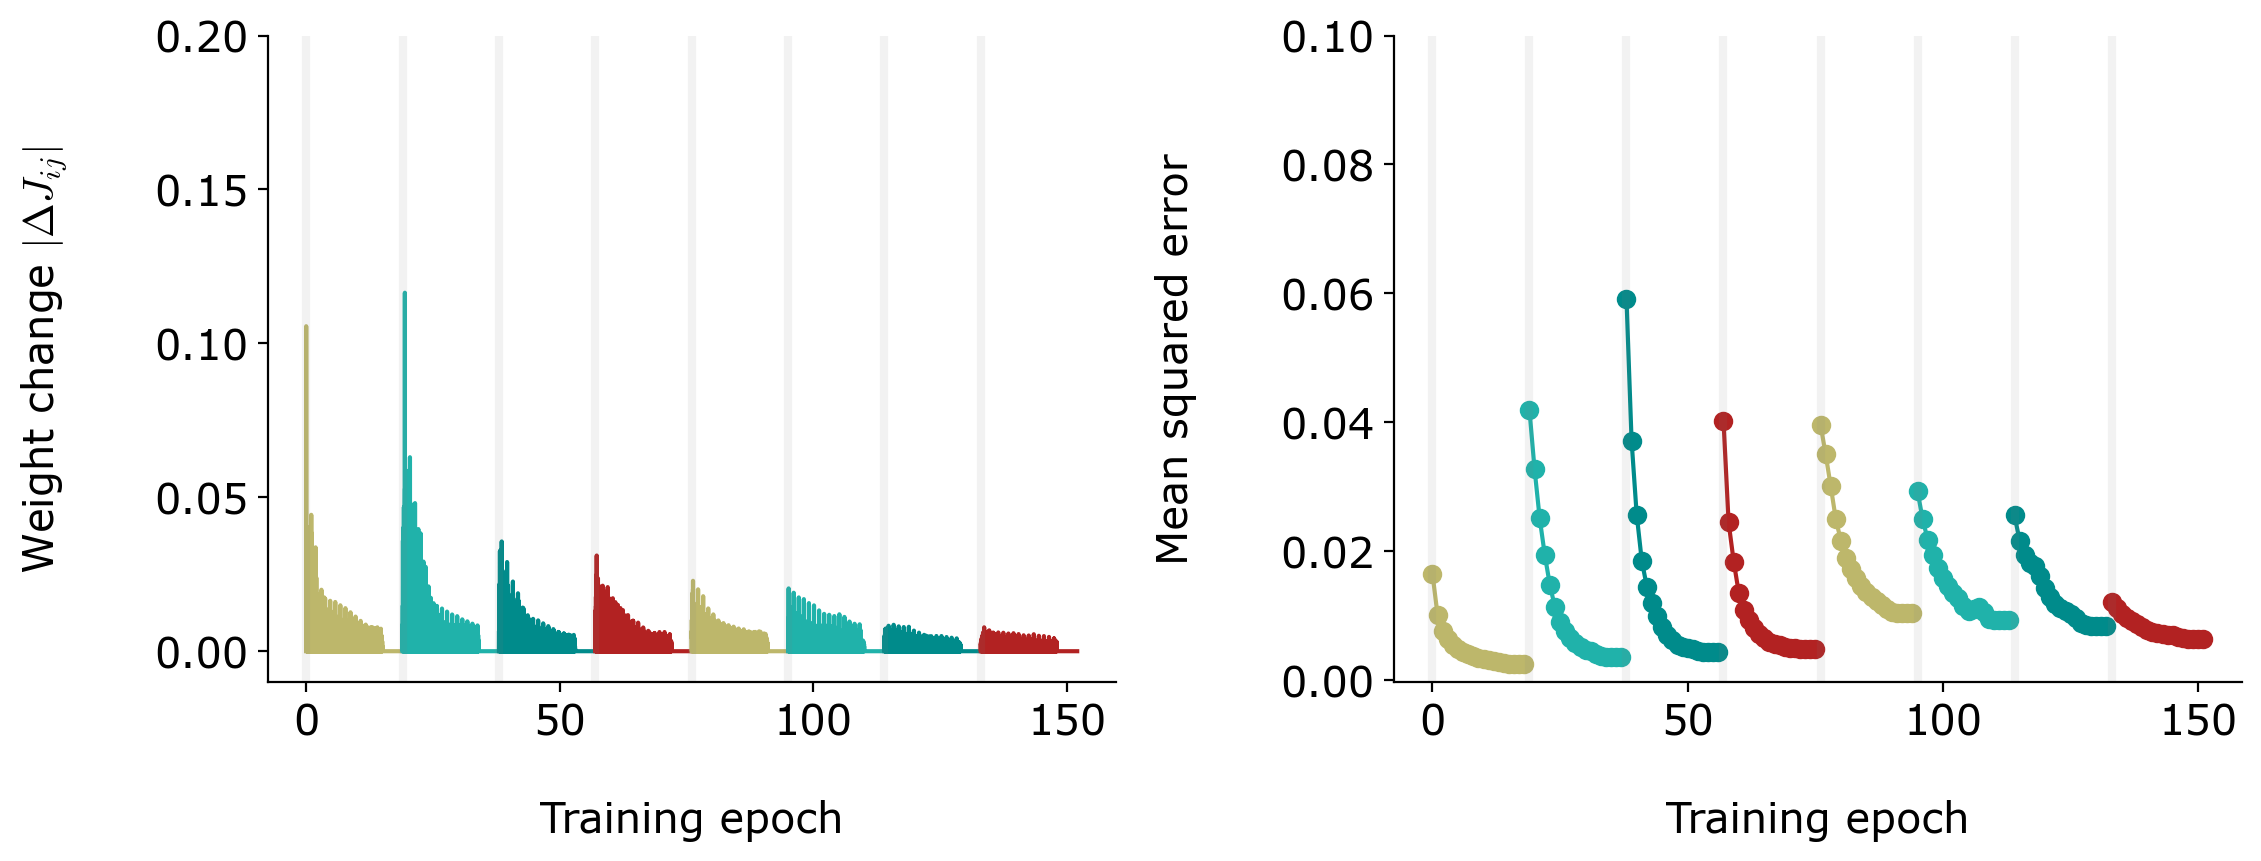

In [309]:
# Weight change and error over learning

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.5, 4.5), dpi=200)

delta_xaxis = np.arange(0, len(deltas_all[0])) / iterations
mses_xaxis = np.arange(0, len(mses))

def from_to(length_per_trial):

    fro = repeat * n_trials * length_per_trial + (length_per_trial * trial)
    to = repeat * n_trials * length_per_trial + (length_per_trial * trial) + length_per_trial
    
    return fro, to

length_per_trial_delta = iterations * (len_train + n_trials)
length_per_trial_chi = (len_train + n_trials)

for repeat in range(n_repeats):
    
    for trial in range(n_trials):
        
        fro1, to1 = from_to(length_per_trial_delta)
        fro2, to2 = from_to(length_per_trial_chi)

        ax1.plot(delta_xaxis[fro1:to1], deltas_all[0, fro1:to1], color=color_palette[trial])
        ax2.plot(mses_xaxis[fro2:to2], mses[fro2:to2], color=color_palette[trial], marker='o')

ax1.set_ylabel(r'Weight change $| \Delta J_{ij} |$', rotation=90, labelpad=30)
ax1.set_xlabel('Training epoch')
for epoch in range(n_trials * n_repeats):
    ax1.axvline((len_train + n_trials) * epoch, color='grey', lw=3, alpha=0.1)
    ax2.axvline((len_train + n_trials) * epoch, color='grey', lw=3, alpha=0.1)
# ax1.set_title('Weight change', fontweight='bold', pad=30)

ax1.set_ylim(-0.01, 0.2)
ax2.set_ylabel(r'Mean squared error', labelpad=30)
ax2.set_xlabel('Training epoch')
# ax2.set_xlim(-0.5, n_tot)
ax2.set_ylim(None, 0.10)
sns.despine(ax=ax1, top=True, right=True)
sns.despine(ax=ax2, top=True, right=True)
fig.tight_layout()
plt.savefig('%s/weight_change.png' %folder, dpi=200)
plt.show()

### Trained connectivity matrix 

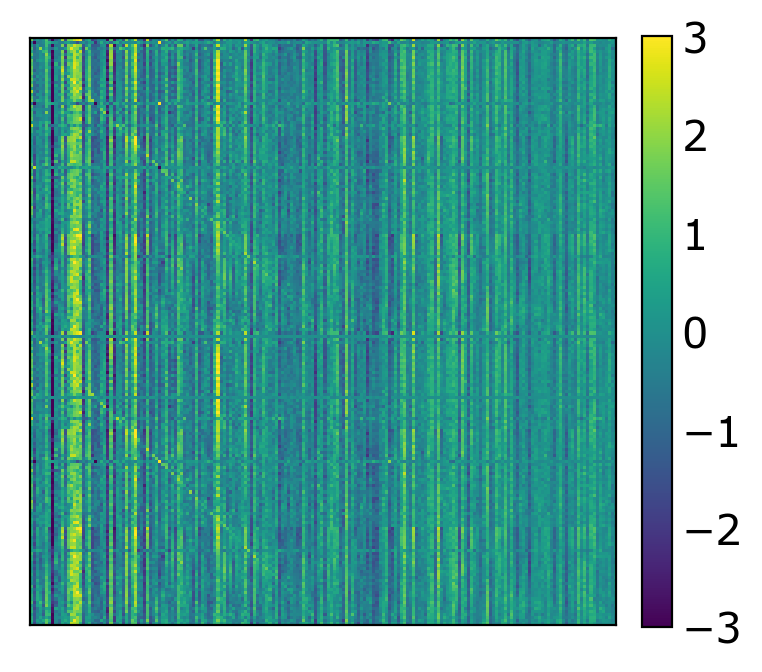

In [310]:
# Visualise matrix as heatmap

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

J_masked = np.ma.masked_where(J==0, J)

scale_limit = 3
im = plt.imshow(J, cmap='viridis', vmin=-scale_limit, vmax=scale_limit)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(size=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('%s/trained_matrix.png' %folder, dpi=200)
plt.show()

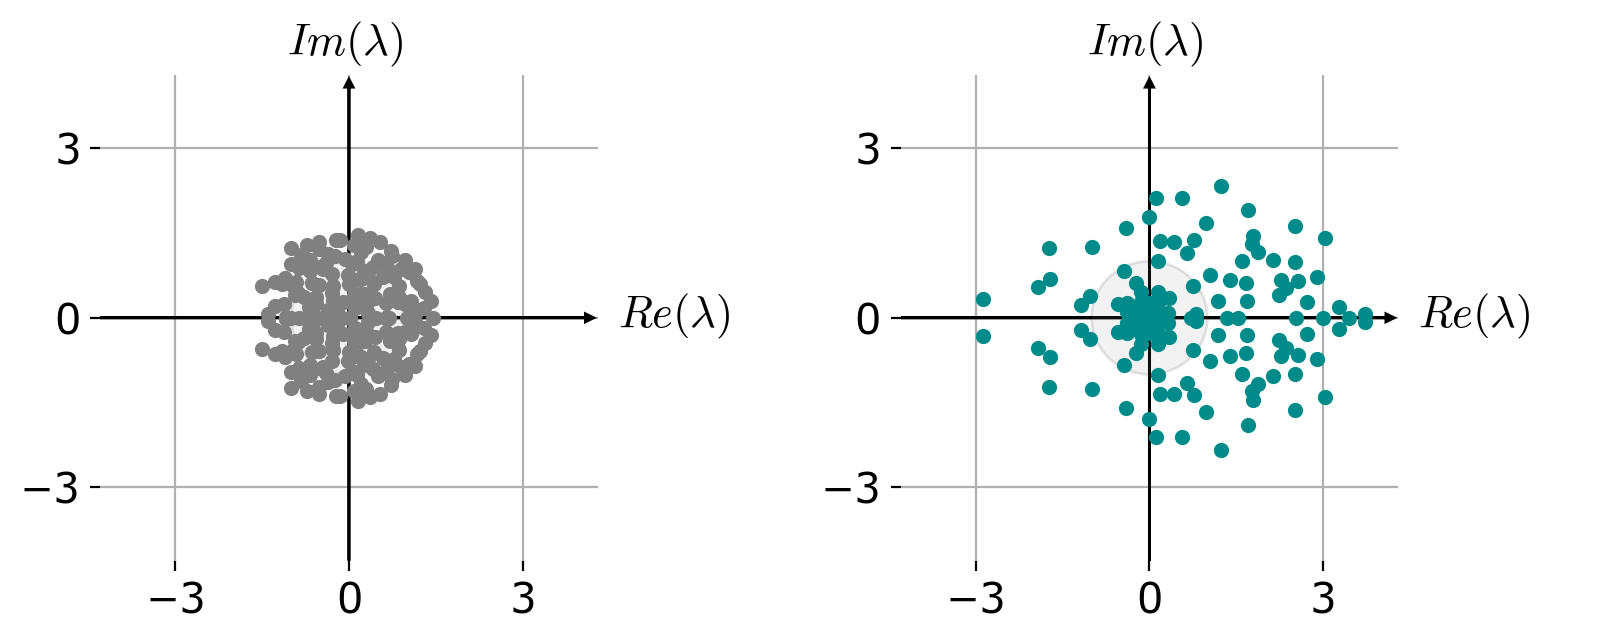

In [311]:
# Eigenspectrum of connectivity matrix

eigvals_J, eigvecs_J = np.linalg.eig(J) 
eigvals_J0, eigvecs_J0 = np.linalg.eig(J0) 

w = 4.3
major_ticks = np.linspace(-3, 3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.2, 3.4), dpi=200)

for ax in (ax1, ax2):
    ax.grid()
    ax.text(-0.25 * w, 1.08 * w, r'$Im(\lambda)$', fontsize=16)
    ax.text(1.08 * w,  -0.04 * w, r'$Re(\lambda)$    ', fontsize=16)
    ax.set_xlim(-w, w)
    ax.set_ylim(-w, w)
    ax.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    ax.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    circle = plt.Circle((0,0), 1, facecolor='grey', alpha=0.1, fill=True, edgecolor='k')
    ax.add_artist(circle)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    ax.set_axisbelow(True)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
for eigval in eigvals_J0:
    ax1.scatter(eigval.real, eigval.imag, color='grey', s=20, zorder=3)

for eigval in eigvals_J:
    ax2.scatter(eigval.real, eigval.imag, color=main_color, s=20, zorder=3)

plt.tight_layout()
plt.savefig('%s/eigenvalues_J.png'%folder, dpi=200)
plt.show()

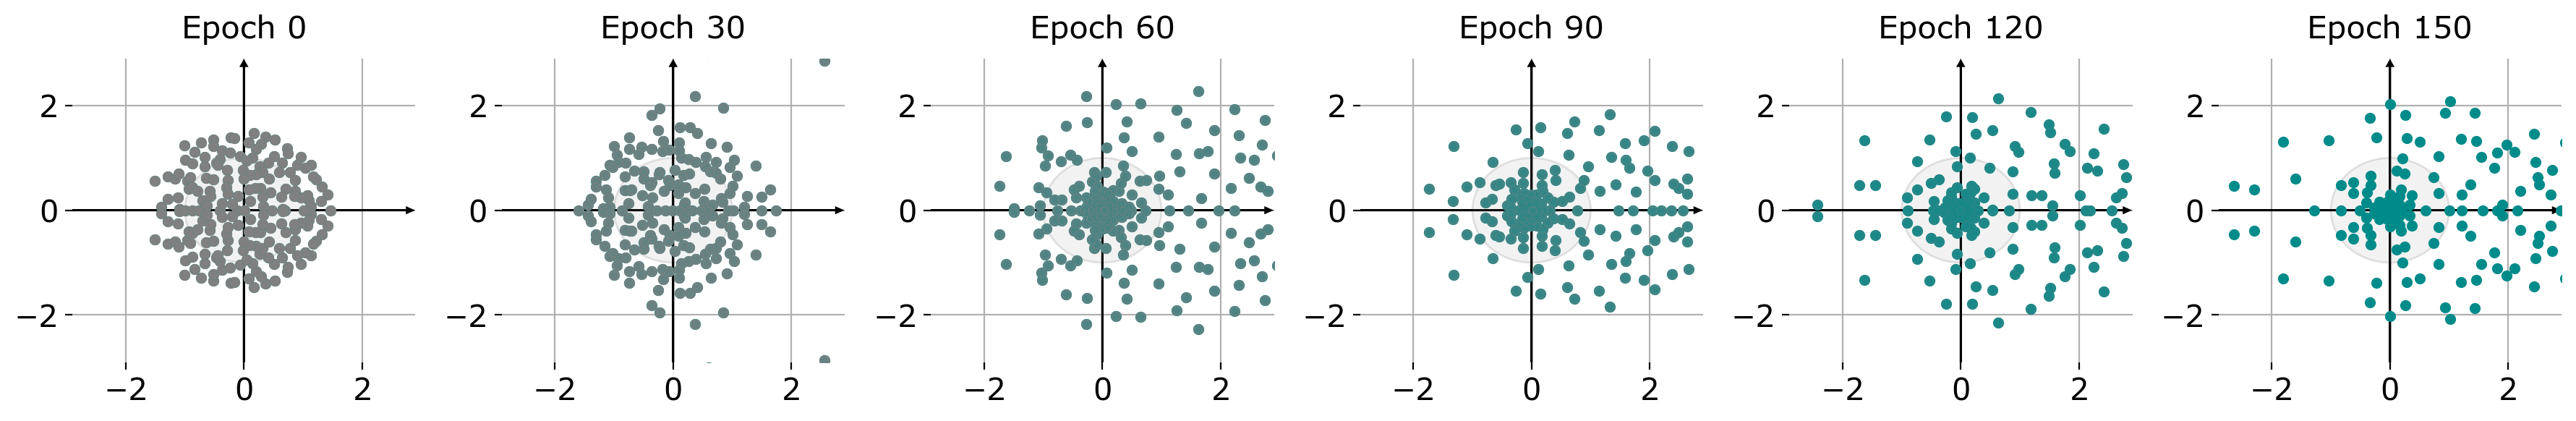

In [312]:
# Plot eigenvalue change over learning 

fig, axs = plt.subplots(1, len(J_evolution)-1, figsize=(18, 3.1), dpi=200)

w = 2.9

alphas = np.linspace(0, 1, len(axs))[::-1] 

for idx, ax in enumerate(axs):
    ax.grid()
    ax.set_xlim(-w, w)
    ax.set_ylim(-w, w)
    ax.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    ax.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    circle = plt.Circle((0,0), 1, facecolor='grey', alpha=0.1, fill=True, edgecolor='k')
    ax.add_artist(circle)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    ax.set_axisbelow(True)
    ax.set_title('Epoch %d' % int(save_J_every*idx))

    eigvals, eigvecs = np.linalg.eig(J_evolution[idx]) 

    for i in range(len(eigvals)):
        x = eigvals[i].real
        y = eigvals[i].imag
        ax.scatter(x, y, color=main_color, s=20, zorder=3)
        ax.scatter(x, y, color='grey', alpha = alphas[idx], s=20, zorder=3)
    
plt.tight_layout()
# plt.savefig('multiple_positive_sigmoid_delay/eigenvalues_evolution_J.png', dpi=200)
plt.show()


### Autonomous dynamics

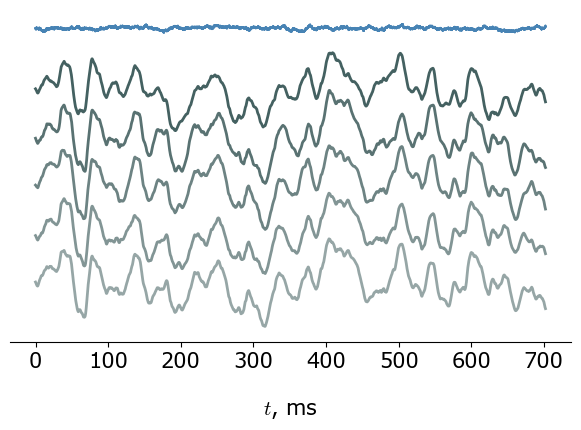

In [315]:
# Run network autonomously 

noise_trial_new = get_noise(N, n_trials, tau_trial, amp_trial, 0.0)
noise_baseline_new = get_noise(N, 1, tau_baseline, amp_baseline, 0.0)
noise_baseline_graded_new = get_noise_amp_graded(N, 1, taus_baseline, amps_baseline, 0) 
noise_trial_graded_new = get_noise_amp_graded(N, n_trials, taus_baseline, amps_baseline, 0)


x1a = np.zeros((N, iterations))
zs_noise = np.zeros((N, iterations-1)) 

for t in range(D, iterations-1):
#     x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + noise_trial_new[0][:, t] + noise_baseline_new[0][0, t]) * dt / tau
    x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + noise_trial_graded_new[0][:, t] + noise_baseline_graded_new[0][:, t]) * dt / tau
    zs_noise[:, t] = J.dot(nonlinearity(x1a[:, t-D]))
                    
# Plot currents over timecourse of target
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)

for i in range(10, 15):
    ax.plot(rescale_ms[:-1], zs_noise[i, :max_length-1] + i , color=main_color_dark, alpha=((i/10 - 1)+0.5), linewidth=2)
    ax.plot(rescale_ms, noise_trial_graded_new[0][0]+15.3, color='steelblue', alpha=.6)

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.savefig('%s/novel_noise.png'%folder, dpi=200)
plt.show()


### Fourier analysis of new noise response

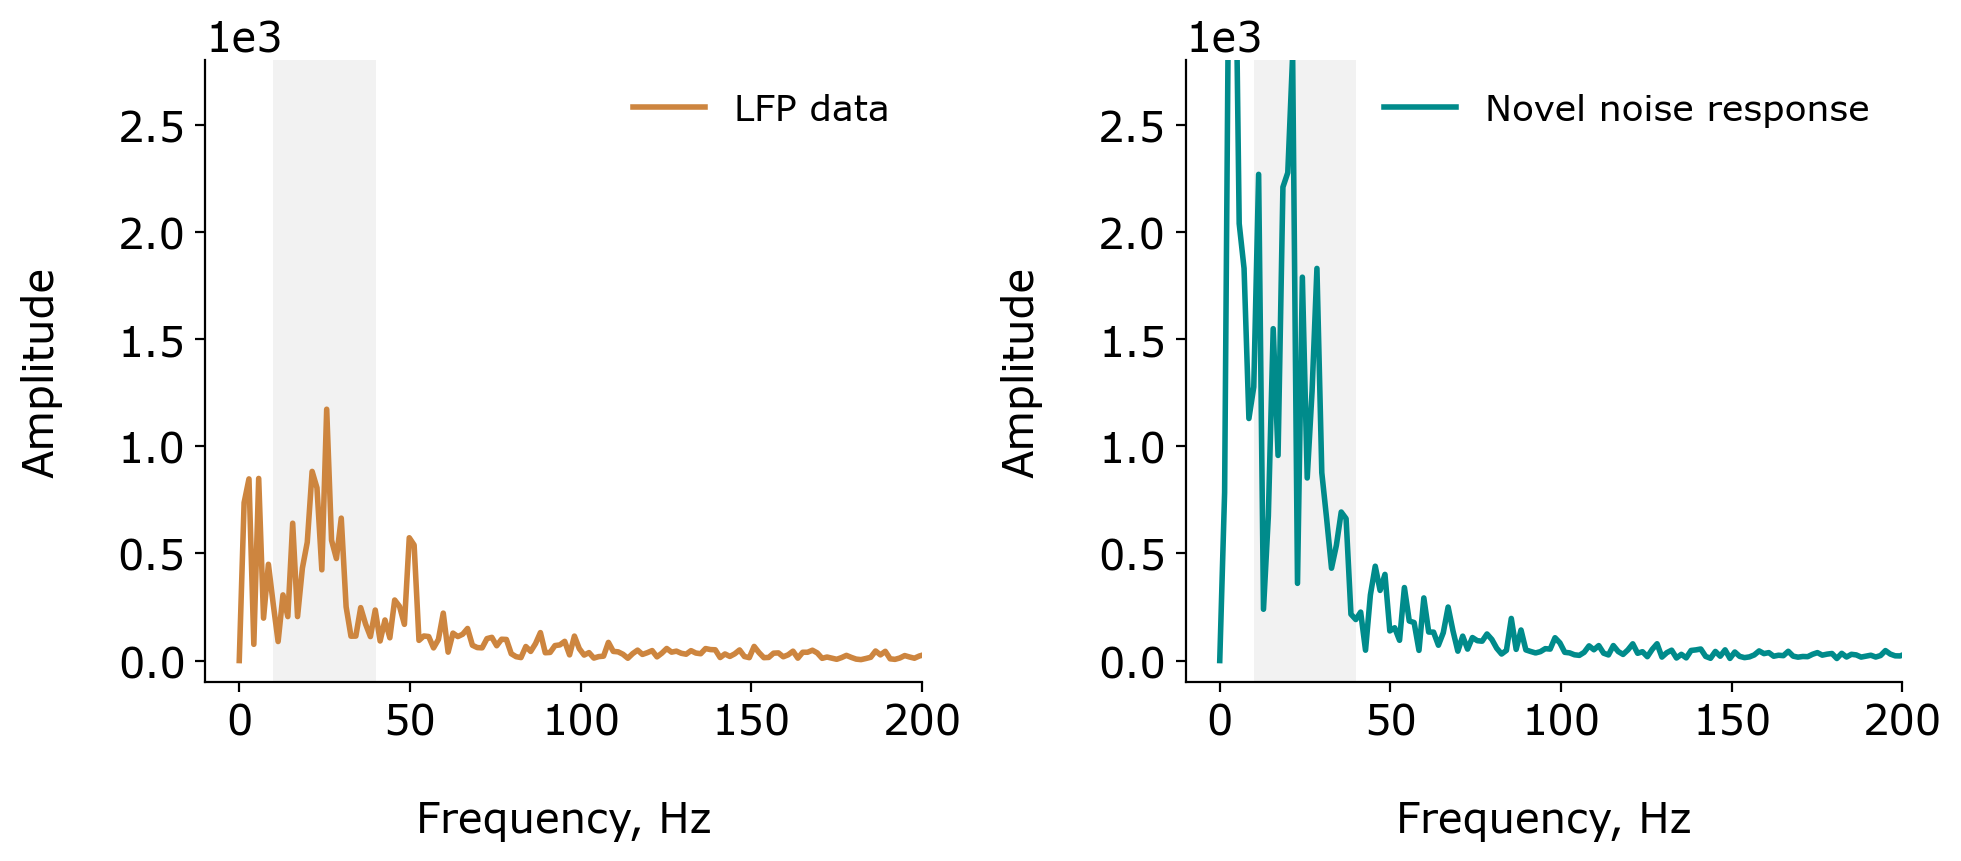

In [296]:
# Fourier analysis of new noise response

trained_response_all = []
noise_response_all = []

for i in range(N):
    if i < n_targets:
        trained_response = targets_duplicated[0][i] - targets_duplicated[0][i].mean()
        yf_trained = rfft(trained_response)
        trained_response_all.append(yf_trained)
    noise_response = zs_noise[i] - zs_noise[i].mean()
    
    yf_noise = rfft(noise_response)
    noise_response_all.append(yf_noise)

trained_response_avg = np.mean(trained_response_all, axis=0)
noise_response_avg = np.mean(noise_response_all, axis=0)

duration_s = float(rescale_ms[-1].magnitude) / 1000  # duration in seconds
sample_rate = len(noise_response)/duration_s  # number of samples per second

xf_noise = rfftfreq(noise_response.size, 1/sample_rate)
xf_trained = rfftfreq(trained_response.size, 1/sample_rate)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), dpi=200)

ax1.plot(xf_trained, np.abs(trained_response_avg), color='peru', lw=2, label='LFP data')
ax2.plot(xf_noise, np.abs(noise_response_avg), color=main_color, lw=2, label='Novel noise response')

for ax in (ax1, ax2):
    ax.set_xlim(-10, 200)
    ax.set_ylim(-100, 2.8*10**3)
    ax.set_xlabel('Frequency, Hz', labelpad=20)
    ax.set_ylabel('Amplitude', labelpad=20)
    ax.axvspan(10, 40, color='grey', ec=None, alpha=0.1)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=True, useMathText=None)
    ax.legend(frameon=False, loc=0, fontsize=13)
    sns.despine(ax=ax, top=True, right=True)
    
fig.tight_layout()
plt.savefig('%s/fourier_spectrum.png' %folder, dpi=200)
plt.show()

### Autocorrelation function of noise response

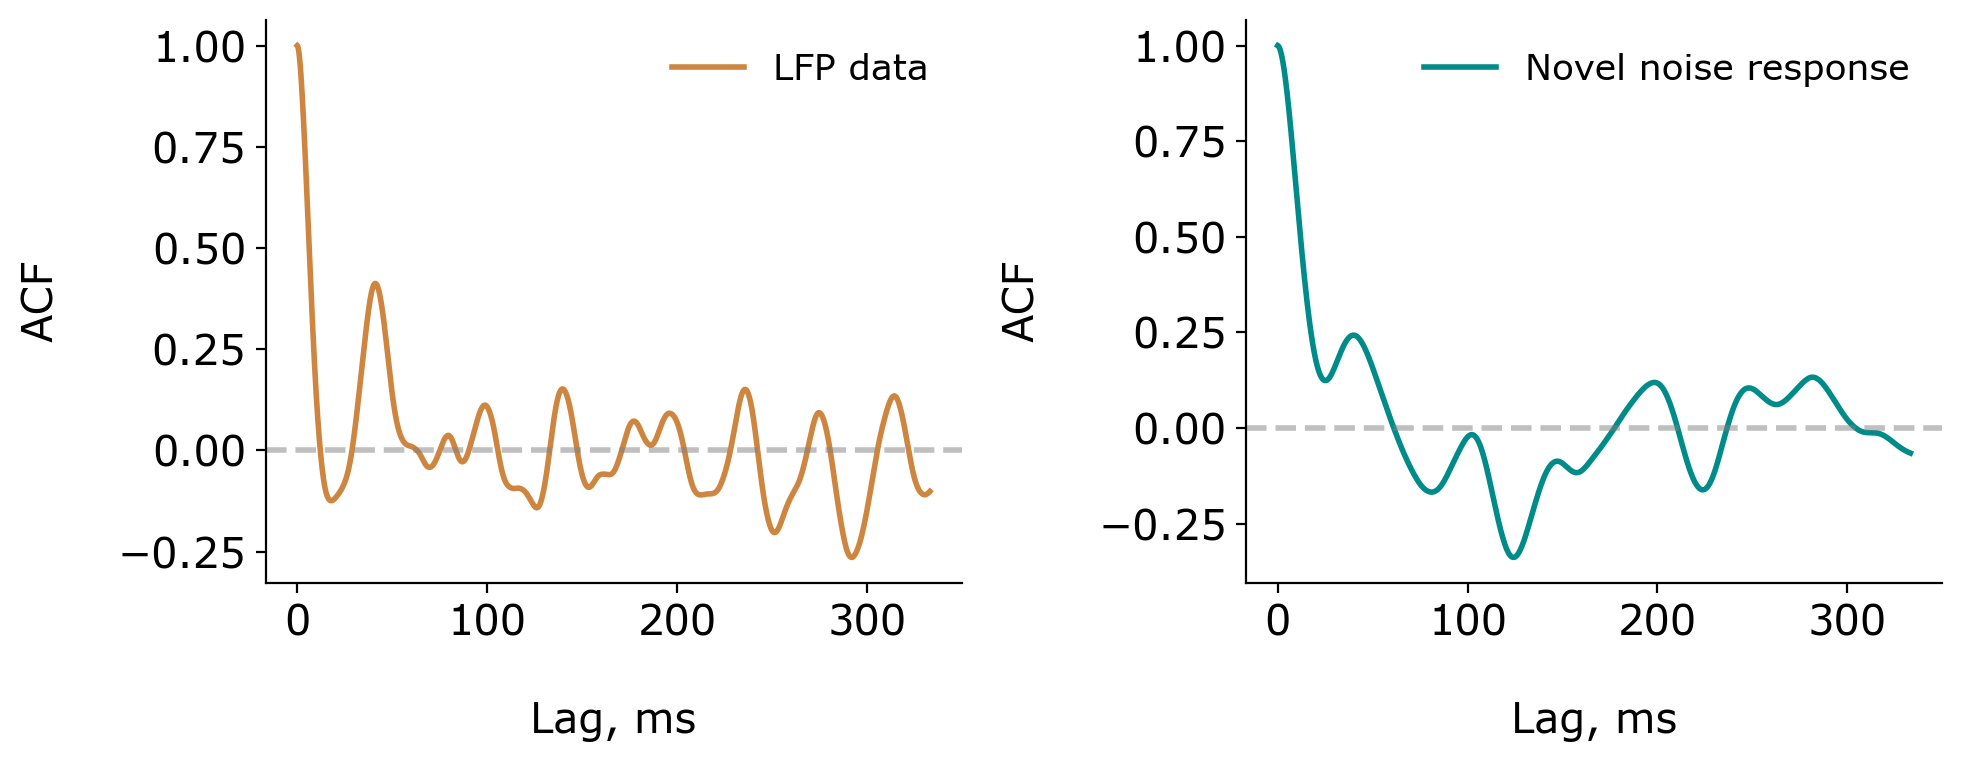

In [297]:
# Autocorrelation of new noise response

lags=range(10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

iterations_to_ms = float(rescale_ms[-1].magnitude) / max_length

ax1.plot(np.arange(0, len(lags))*iterations_to_ms, autocorr(targets_duplicated[0][0], lags), lw=2, color='peru', label='LFP data')
ax2.plot(np.arange(0, len(lags))*iterations_to_ms, autocorr(zs_noise[8], lags), lw=2, color=main_color, label='Novel noise response')

for ax in (ax1, ax2):
    ax.axhline(0, color='grey', alpha=0.5, lw=2, ls='--')
    ax.set_xlabel('Lag, ms', labelpad=20) # convert to ms
    ax.set_ylabel('ACF', labelpad=20)

    ax.legend(frameon=False, loc=0, fontsize=13)
    sns.despine(ax=ax, top=True, right=True)
    
fig.tight_layout()
plt.savefig('%s/autocorrelation.png' %folder, dpi=200)
plt.show()



### Response to pulse input

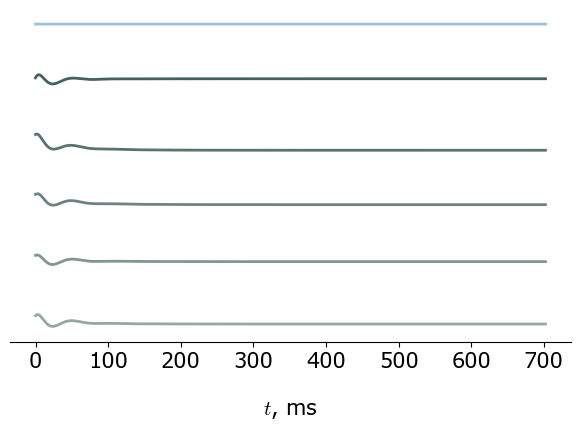

In [298]:
# Run network autonomously with input pulse

amp_pulse = 1
duration_pulse = 200
start_pulse = int(iterations/4)
stop_pulse = int(start_pulse + duration_pulse)

pulse_input = np.zeros((N, iterations))
# pulse_input[:, start_pulse:stop_pulse] = np.tile(eigvecs_jacobian[0].real[:, None], duration_pulse) * 10
# pulse_input[:, start_pulse:stop_pulse] = np.tile(np.random.randn(N)[:, None], duration_pulse) * 2

x1a = np.zeros((N, iterations))
zsa = np.zeros((N, iterations-1)) 

# x1a[:, 0] = fixed_point # initial condition

for t in range(iterations-1):
    x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + pulse_input[:, t]) * dt / tau
    zsa[:, t] = J.dot(nonlinearity(x1a[:, t+1]))
                    
# Plot currents over timecourse of target
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)

for i in range(10, 15): 
    ax.plot(rescale_ms[:-1], zsa[i, :max_length-1] + i , color=main_color_dark, alpha=((i/10 - 1)+0.5), linewidth=2)

ax.plot(rescale_ms, pulse_input[0] + 15, color='steelblue', lw=2, alpha=0.5)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.show()



### Linear stability analysis

In [299]:
def system(x, J, D):
    return (-x + J.dot(nonlinearity(x-D/tau)))/tau  # necessary to put D in?

def q(x, J):
    return 1/2 * np.linalg.norm(system(x, J))**2

# Fixed point found by running the dynamics
fixed_point = zsa[:, -1]

# Define Jacobian
jacobian_sys = nd.Jacobian(system)
jacobian_fp = jacobian_sys(fixed_point, J, D)

# Plot eigenvalues of Jacobian at fixed point
eigvals_jacobian, eigvecs_jacobian = np.linalg.eig(jacobian_fp) 

# Sort eigenvalues in descending order
idx = eigvals_jacobian.argsort()[::-1]   
eigvals_jacobian = eigvals_jacobian[idx]
eigvecs_jacobian = eigvecs_jacobian[:,idx]

In [300]:
# Frequency of oscillations

print('Frequency: ', eigval_to_hz(max(eigvals_jacobian.imag)))
print('Max real:', max(eigvals_jacobian.real), '  Index', np.argmax(eigvals_jacobian.real))
print('Min real:', min(eigvals_jacobian.real), '  Index', np.argmin(eigvals_jacobian.real))
print('Max imag:', max(eigvals_jacobian.imag), '  Index', np.argmax(eigvals_jacobian.imag))


Frequency:  26.51082351003672
Max real: -0.0007071790291577916   Index 0
Min real: -0.02855959415173314   Index 191
Max imag: 0.0055521504197475775   Index 162


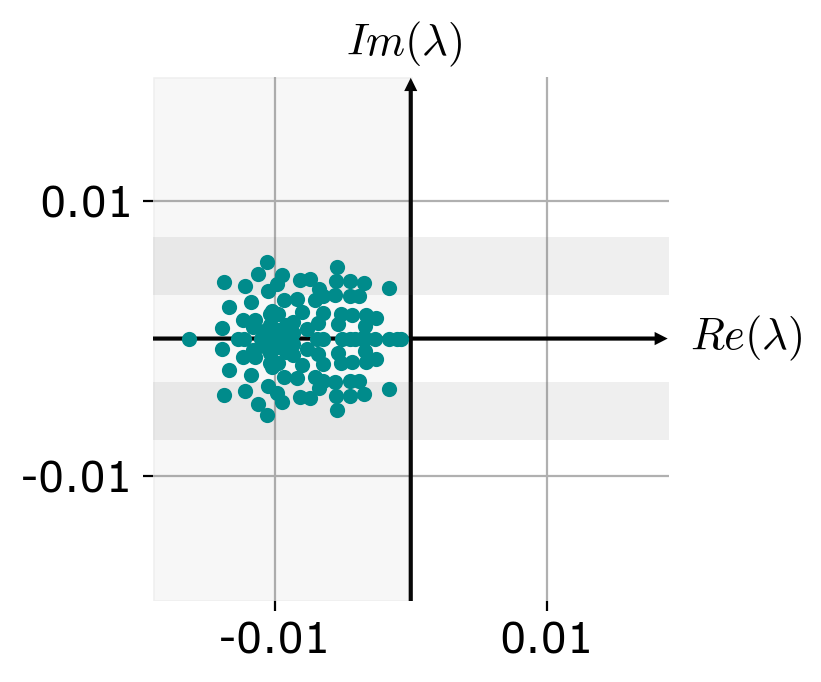

In [301]:
w = 0.019
fig, ax = plt.subplots(figsize=(4.3, 3.6), dpi=200)

plt.axis('on')
plt.grid()
plt.text(-0.25 * w, 1.08 * w, r'$Im(\lambda)$', fontsize=16)
plt.text(1.08 * w,  -0.04 * w, r'$Re(\lambda)$', fontsize=16)
plt.xlim(-w, w)
plt.ylim(-w, w)
plt.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
plt.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)

for i in range(len(eigvals)):
    x = eigvals_jacobian[i].real
    y = eigvals_jacobian[i].imag
    plt.scatter(x, y, color='darkcyan', s=20, zorder=3)

circle = plt.Circle((0,0), 1, color='k', alpha=0.2, fill=False)
plt.gcf().gca().add_artist(circle)

ax.axvspan(-w, 0, alpha=0.05, color='dimgrey')
ax.axhspan(hz_to_eigval(15), hz_to_eigval(35), alpha=0.1, color='dimgrey', ec=None)
ax.axhspan(hz_to_eigval(-15), hz_to_eigval(-35), alpha=0.1, color='dimgrey', ec=None)

ax.set_xticks([-0.01, 0.01])
ax.set_xticklabels([-0.01, 0.01])
ax.set_yticks([-0.01, 0.01])
ax.set_yticklabels([-0.01, 0.01])

sns.despine(top=True, right=True, left=True, bottom=True)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('%s/eigenvalues_jacobian.png'%folder, dpi=230)
plt.show()

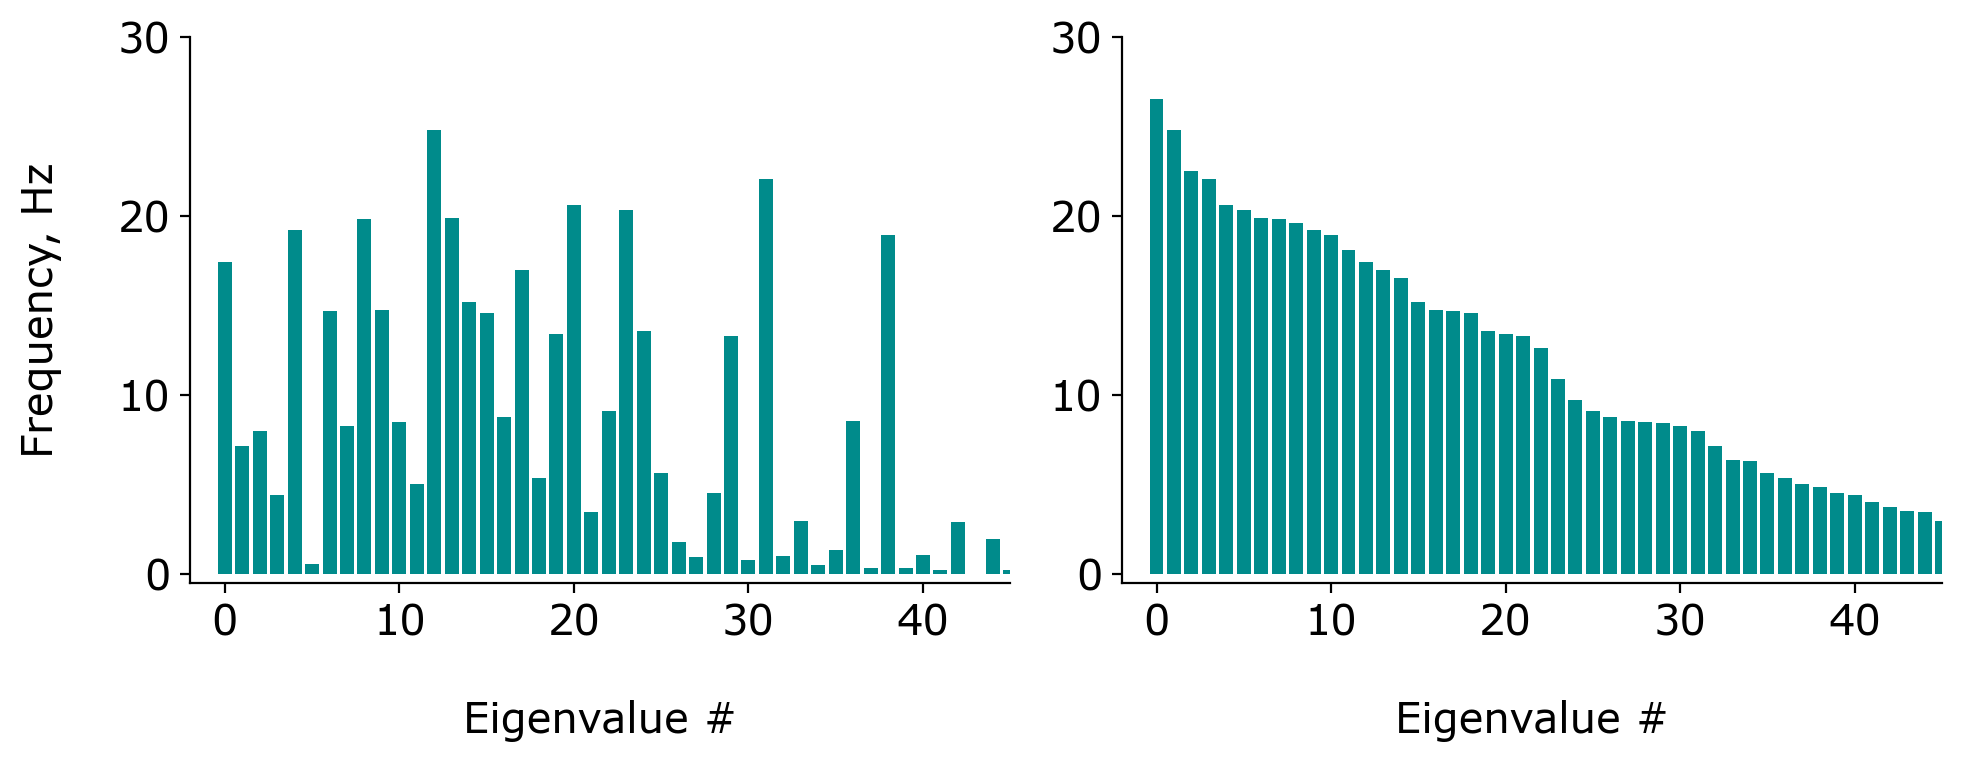

In [302]:
# Plot frequencies of each eigenvalue 

frequencies = [eigval_to_hz(x) for x in eigvals_jacobian.imag]

freq_unique = np.delete(np.array(frequencies), np.array(frequencies)<=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax1.bar(range(len(freq_unique)), freq_unique, color=main_color)
ax2.bar(range(len(sorted(frequencies, reverse=True))), sorted(frequencies, reverse=True), color=main_color)

for ax in (ax1, ax2):
    ax.add_patch(patches.Rectangle((-1, -0.5), 100, 0.5, facecolor='white', fill=True))
    ax.set_xlabel('Eigenvalue #', labelpad=20)
    ax.set_ylim(-.5, 30)
    if ax==ax1:
        ax.set_ylabel('Frequency, Hz', labelpad=20)
    ax.set_xlim(-2, 45)
    sns.despine(ax=ax, top=True, right=True)

fig.tight_layout()
plt.savefig('%s/frequencies.png'%folder, dpi=200)
plt.show()


### Matrix histogram

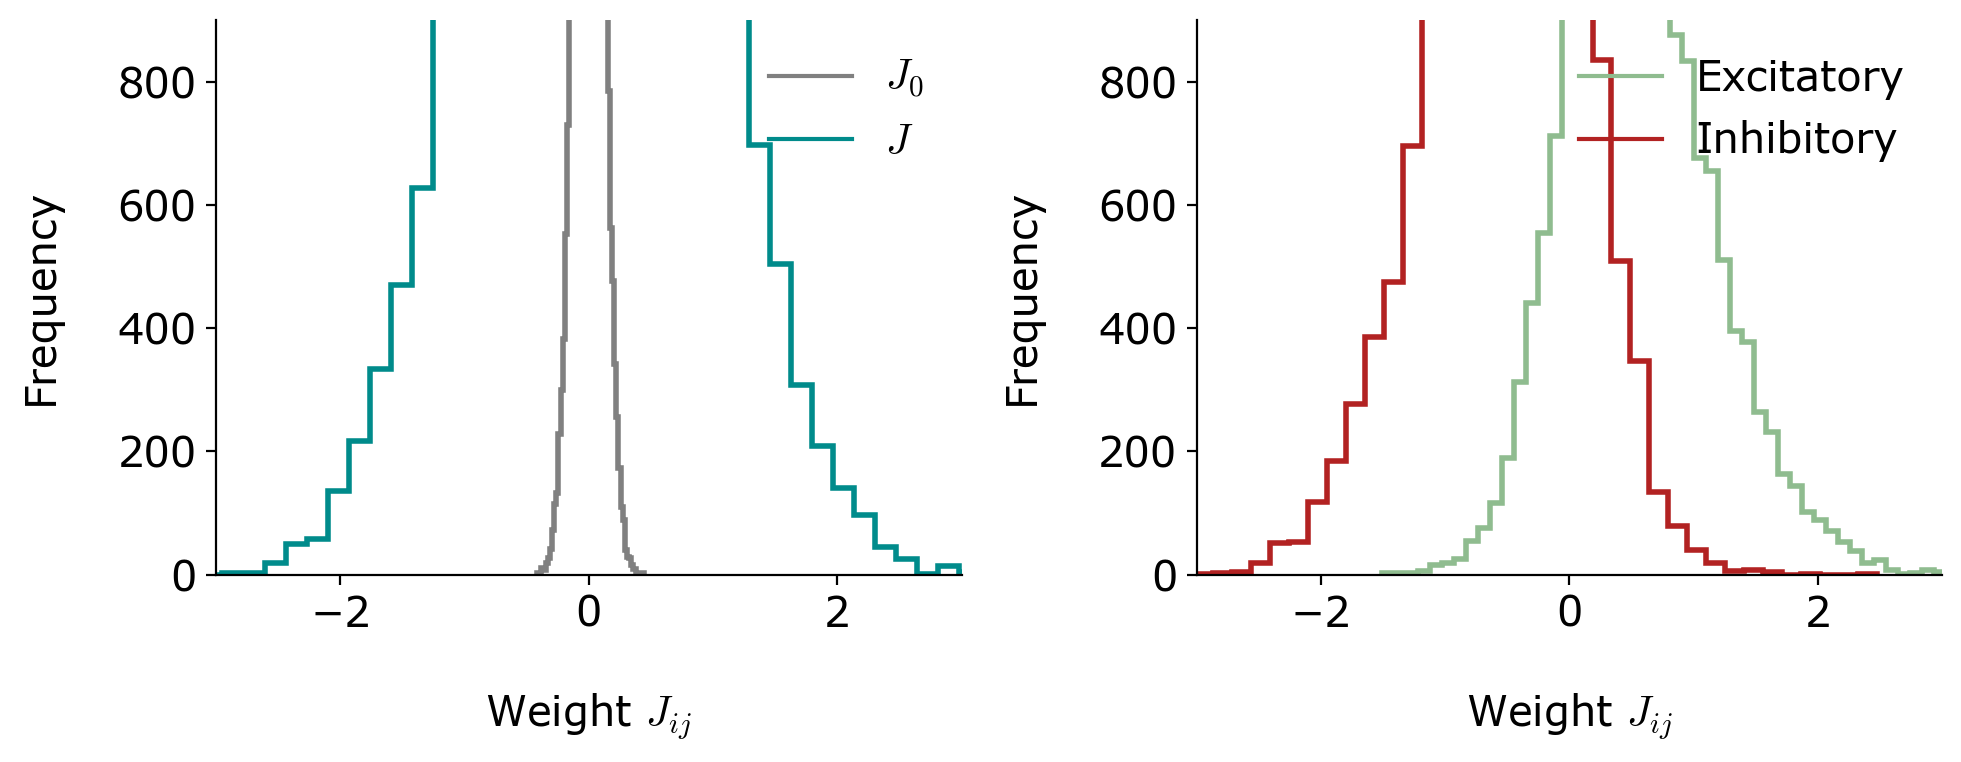

In [111]:
# Histogram of matrix values before and after training

pos_idx = np.mean(J, axis=0)>=0
neg_idx = np.mean(J, axis=0)<0

J_exc = J[:, pos_idx] # matrix columns in which mean is positive
J_inh = J[:, neg_idx] # matrix columns in which mean is negative

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax1.hist(J0.flatten(), histtype='step', bins=50, lw=2, color='grey', alpha=1,)
ax1.hist(J.flatten(), histtype='step', bins=50, lw=2, color='darkcyan')
ax1.plot(0, 0, color='grey', label=r'$J_0$')
ax1.plot(0, 0, color='darkcyan', label=r'$J$')

ax2.hist(J_exc.flatten(), histtype='step', bins=50, lw=2, color='darkseagreen')
ax2.hist(J_inh.flatten(), histtype='step', bins=50, lw=2, color='firebrick')
ax2.plot(0, 0, color='darkseagreen', label='Excitatory')
ax2.plot(0, 0, color='firebrick', label='Inhibitory')

for ax in (ax1, ax2):
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 900)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(r'Weight $J_{ij}$', labelpad=20)
    ax.legend(frameon=False, loc=0, fontsize=15)
    sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
plt.savefig('%s/matrix_histogram.png'%folder, dpi=200)
plt.show()


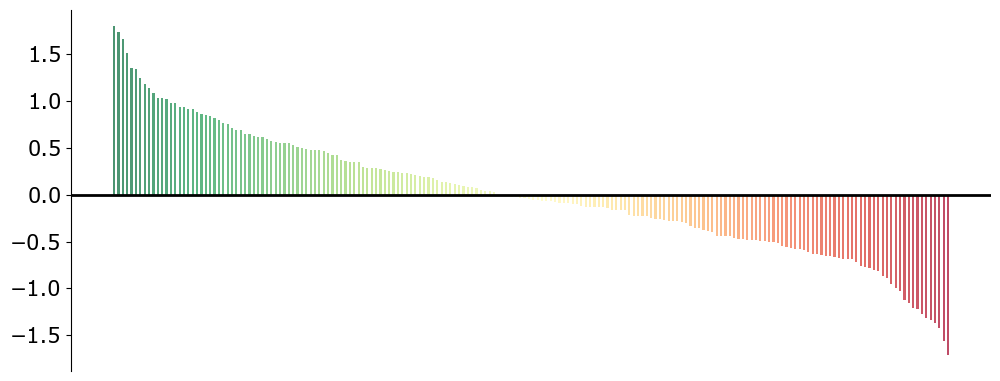

In [112]:
fig, ax = plt.subplots(figsize=(10.2, 4), dpi=100)
red_green = pl.cm.RdYlGn(np.linspace(1, 0, N))
ax.bar(np.arange(0, N), sorted(np.mean(J, axis=0), reverse=True), width=0.5, color=red_green, alpha=0.7, linewidth=2)
ax.axhline(0, color='k', lw=2)
ax.get_xaxis().set_visible(False)
sns.despine(ax=ax, top=True, right=True, bottom=True, left=False)
fig.tight_layout()
plt.show()

### Weights visualised on electrode grid

In [127]:
blackrock_elid_list = bl_raw.annotations['avail_electrode_ids']
corrected = [[-1] if x==-1 else x for x in blackrock_elid_list]
flattened = [val for sublist in corrected for val in sublist]
reshape = np.flip(np.reshape(flattened, (10, 10)), axis=0)
reshape = reshape-1
reshape_unravelled = reshape.ravel()

filenames = []

for ind, unit in enumerate(reshape_unravelled):
    
    if unit != -2:
        
        filenames.append('weights_visualised/position%s.jpg' %ind)

        outgoing_weights = J[:, unit]
        incoming_weights = J[unit, :]

        outgoing_weights_reshape = np.reshape(outgoing_weights[reshape_unravelled], (10, 10))
        outgoing_weights_reshape_masked = np.ma.masked_where(reshape==-2, outgoing_weights_reshape)
        outgoing_weights_reshape_selected = np.ma.masked_where(reshape!=unit, outgoing_weights_reshape)

        fig, ax = plt.subplots(figsize=(4.2, 4), dpi=100)

        if outgoing_weights.max() >= 3 or outgoing_weights.min() <= -3:
            scale_limit = 4
        else:
            scale_limit = 3

        im = plt.imshow(outgoing_weights_reshape_masked, cmap='viridis', vmin=-scale_limit, vmax=scale_limit)
        im2 = plt.imshow(outgoing_weights_reshape_selected, cmap='Set1')
        cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(size=0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Electrode ID: %s' %unit, pad=20)
        plt.savefig('weights_visualised/position%s.jpg' %ind, dpi=200)
        plt.close(fig)

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('weights_visualised_multiple.gif', images, duration=0.2)



### PCA

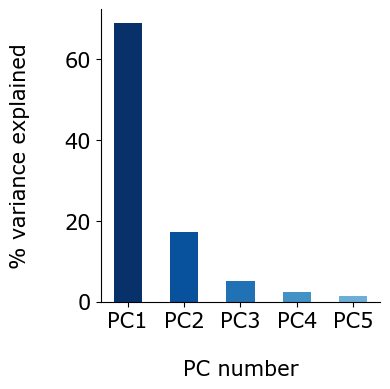

In [124]:
# Eigenvalues and eigenvectors

covmat = zs_all[-1].dot(zs_all[-1].T)
eigvals, eigvecs = np.linalg.eigh(covmat)
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]

# Percentage variance explained by each eigenvalue
var_exp_readouts = [(i / np.sum(eigvals)) * 100 for i in eigvals]  

fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 5))
ax.bar((0, 1, 2, 3, 4), (var_exp_readouts[0], var_exp_readouts[1], var_exp_readouts[2], var_exp_readouts[3], var_exp_readouts[4]), color=colors, width=0.5)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax.set_xlabel("PC number", labelpad=20)
ax.set_ylabel("% variance explained", labelpad=25)

sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


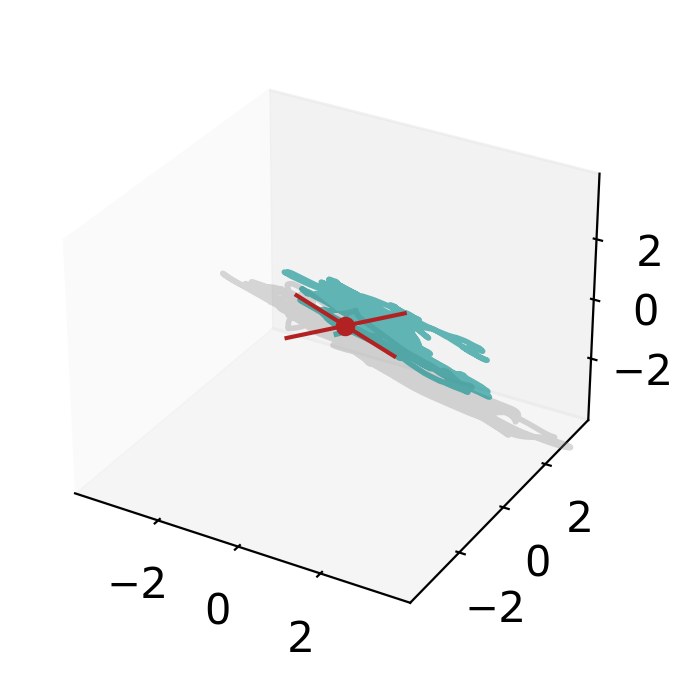

In [125]:
# Projection of readouts onto first PCs

%matplotlib notebook 
%matplotlib notebook 

# Projections 
projs = np.dot(zs_all[-1].T, eigvecs[:, 0:3])
projs_fp = np.dot(fixed_point.T, eigvecs[:, 0:3])
projs_noise = np.dot(zs_noise.T, eigvecs[:, 0:3])
projs_eigvec1 = np.dot(eigvecs_jacobian[0].real.T, eigvecs[:, 0:3])
projs_eigvec2 = np.dot(eigvecs_jacobian[1].real.T, eigvecs[:, 0:3])

projs_targets1 = np.dot(targets_duplicated[0].T, eigvecs[:n_targets, 0:3])

# Eigenvector direction lines
length_line = 10
start_point_eigvec1 = projs_fp - (projs_eigvec1.real) * length_line
start_point_eigvec2 = projs_fp - (projs_eigvec2.real) * length_line
end_point_eigvec1 = projs_fp + (projs_eigvec1.real) * length_line
end_point_eigvec2 = projs_fp + (projs_eigvec2.real) * length_line
eigvec1_line = np.vstack((start_point_eigvec1, end_point_eigvec1))
eigvec2_line = np.vstack((start_point_eigvec2, end_point_eigvec2))

max_val = np.max(projs[:, 0]) - 0

fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot(projs_targets1[:, 0], projs_targets1[:, 1], projs_targets1[:, 2], lw=2, color='grey', alpha=0.3)
ax.plot(projs[:, 0], projs[:, 1], projs[:, 2], lw=2, color='darkcyan', alpha=0.6)
# ax.plot(projs_noise[:, 0], projs_noise[:, 1], projs_noise[:, 2], lw=2, color='steelblue', alpha=0.4)
ax.plot(eigvec1_line[:, 0], eigvec1_line[:, 1], eigvec1_line[:, 2], color='firebrick')
ax.plot(eigvec2_line[:, 0], eigvec2_line[:, 1], eigvec2_line[:, 2], color='firebrick')
ax.plot(projs_fp[0], projs_fp[1], projs_fp[2], marker='o', markersize=6, color='firebrick')
ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

ax.w_xaxis.set_pane_color((0.98, 0.98, 0.98, 0.98))

plt.tight_layout()
# plt.savefig('multiple_positive_sigmoid_delay/PCA.png', dpi=200)
plt.show()